# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset)
    del train_dataset

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)
    del val_dataset, test_dataset

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=16, bias=True)
    (lin2): Linear(in_features=16, out_features=8, bias=True)
    (lin): Linear(in_features=8, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

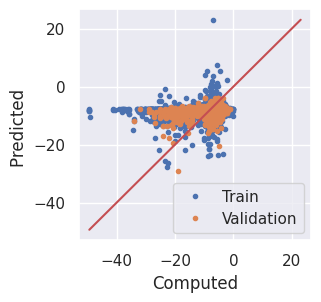

Epoch: 1, Train MAE: 3.4008, Val MAE: 3.1210
Epoch: 2, Train MAE: 3.3050, Val MAE: 3.0886
Epoch: 3, Train MAE: 3.2743, Val MAE: 3.0612
Epoch: 4, Train MAE: 3.2537, Val MAE: 3.0549
Epoch: 5, Train MAE: 3.2308, Val MAE: 3.0519
Epoch: 6, Train MAE: 3.2313, Val MAE: 3.0387
Epoch: 7, Train MAE: 3.2151, Val MAE: 3.0374
Epoch: 8, Train MAE: 3.2075, Val MAE: 3.0346
Epoch: 9, Train MAE: 3.1892, Val MAE: 3.0309
Epoch: 10, Train MAE: 3.1781, Val MAE: 3.0147


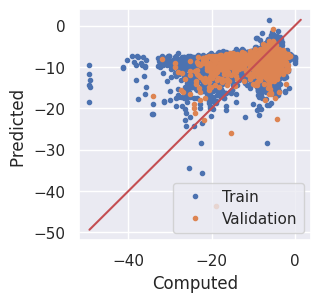

Epoch: 11, Train MAE: 3.1711, Val MAE: 3.0236
Epoch: 12, Train MAE: 3.1839, Val MAE: 2.9762
Epoch: 13, Train MAE: 3.1618, Val MAE: 2.9917
Epoch: 14, Train MAE: 3.1520, Val MAE: 3.0121
Epoch: 15, Train MAE: 3.1504, Val MAE: 2.9656
Epoch: 16, Train MAE: 3.1412, Val MAE: 2.9695
Epoch: 17, Train MAE: 3.1294, Val MAE: 2.9486
Epoch: 18, Train MAE: 3.1178, Val MAE: 2.9510
Epoch: 19, Train MAE: 3.1180, Val MAE: 2.9757
Epoch: 20, Train MAE: 3.1087, Val MAE: 2.9475


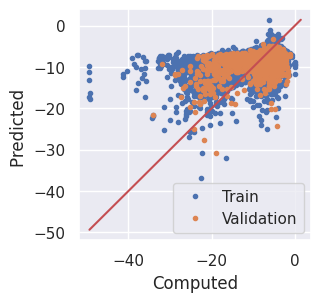

Epoch: 21, Train MAE: 3.1165, Val MAE: 2.9537
Epoch: 22, Train MAE: 3.1129, Val MAE: 2.9405
Epoch: 23, Train MAE: 3.0953, Val MAE: 2.9354
Epoch: 24, Train MAE: 3.0924, Val MAE: 2.9257
Epoch: 25, Train MAE: 3.0869, Val MAE: 2.9323
Epoch: 26, Train MAE: 3.0994, Val MAE: 2.9611
Epoch: 27, Train MAE: 3.0930, Val MAE: 2.9376
Epoch: 28, Train MAE: 3.0796, Val MAE: 2.9206
Epoch: 29, Train MAE: 3.0645, Val MAE: 2.9255
Epoch: 30, Train MAE: 3.0747, Val MAE: 2.9287


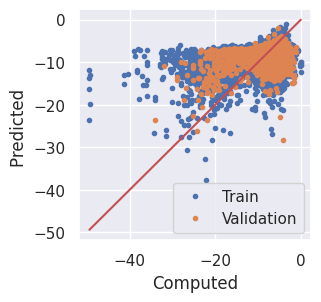

Epoch: 31, Train MAE: 3.0790, Val MAE: 2.9306
Epoch: 32, Train MAE: 3.0679, Val MAE: 2.9153
Epoch: 33, Train MAE: 3.0600, Val MAE: 2.9159
Epoch: 34, Train MAE: 3.0700, Val MAE: 2.9118
Epoch: 35, Train MAE: 3.0513, Val MAE: 2.9273
Epoch: 36, Train MAE: 3.0448, Val MAE: 2.9279
Epoch: 37, Train MAE: 3.0528, Val MAE: 2.9236
Epoch: 38, Train MAE: 3.0478, Val MAE: 2.9408
Epoch: 39, Train MAE: 3.0481, Val MAE: 2.9205
Epoch: 40, Train MAE: 3.0352, Val MAE: 2.9092


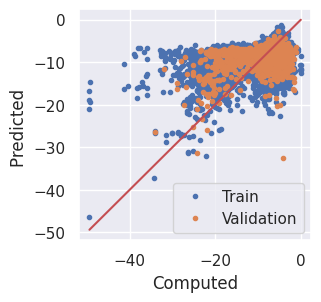

Epoch: 41, Train MAE: 3.0266, Val MAE: 2.9186
Epoch: 42, Train MAE: 3.0361, Val MAE: 2.9194
Epoch: 43, Train MAE: 3.0295, Val MAE: 2.8952
Epoch: 44, Train MAE: 3.0220, Val MAE: 2.9208
Epoch: 45, Train MAE: 3.0265, Val MAE: 2.9035
Epoch: 46, Train MAE: 3.0228, Val MAE: 2.8980
Epoch: 47, Train MAE: 3.0200, Val MAE: 2.9183
Epoch: 48, Train MAE: 3.0161, Val MAE: 2.8922
Epoch: 49, Train MAE: 3.0070, Val MAE: 2.8973
Epoch: 50, Train MAE: 3.0128, Val MAE: 2.9139


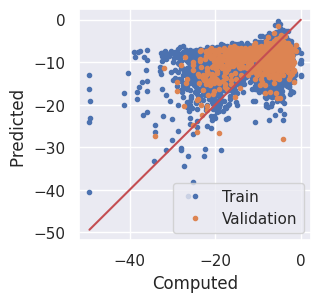

Epoch: 51, Train MAE: 3.0186, Val MAE: 2.8937
Epoch: 52, Train MAE: 3.0016, Val MAE: 2.9043
Epoch: 53, Train MAE: 3.0020, Val MAE: 2.9119
Epoch: 54, Train MAE: 3.0022, Val MAE: 2.9315
Epoch: 55, Train MAE: 3.0024, Val MAE: 2.8934
Epoch: 56, Train MAE: 2.9937, Val MAE: 2.8881
Epoch: 57, Train MAE: 2.9934, Val MAE: 2.9206
Epoch: 58, Train MAE: 2.9795, Val MAE: 2.9345
Epoch: 59, Train MAE: 2.9962, Val MAE: 2.9127
Epoch: 60, Train MAE: 3.0040, Val MAE: 2.8994


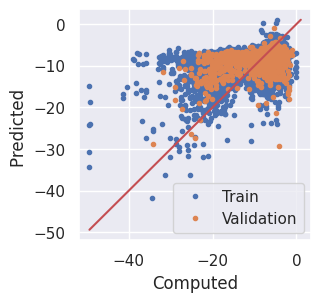

Epoch: 61, Train MAE: 2.9827, Val MAE: 2.9380
Epoch: 62, Train MAE: 2.9871, Val MAE: 2.8984
Epoch: 63, Train MAE: 2.9893, Val MAE: 2.8978
Epoch: 64, Train MAE: 2.9645, Val MAE: 2.9172
Epoch: 65, Train MAE: 2.9935, Val MAE: 2.9146
Epoch: 66, Train MAE: 2.9782, Val MAE: 2.9324
Epoch: 67, Train MAE: 2.9573, Val MAE: 2.9147
Epoch: 68, Train MAE: 2.9772, Val MAE: 2.9095
Epoch: 69, Train MAE: 2.9743, Val MAE: 2.9084
Epoch: 70, Train MAE: 2.9618, Val MAE: 2.9222


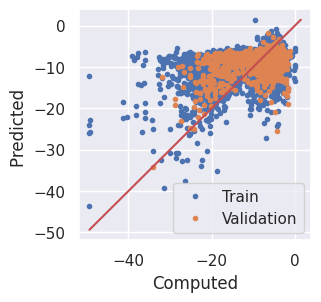

Epoch: 71, Train MAE: 2.9725, Val MAE: 2.8930
Epoch: 72, Train MAE: 2.9597, Val MAE: 2.8902
Epoch: 73, Train MAE: 2.9496, Val MAE: 2.9621
Epoch: 74, Train MAE: 2.9614, Val MAE: 2.8953
Epoch: 75, Train MAE: 2.9441, Val MAE: 2.9078
Epoch: 76, Train MAE: 2.9664, Val MAE: 2.9077
Epoch: 77, Train MAE: 2.9612, Val MAE: 2.9108
Epoch: 78, Train MAE: 2.9357, Val MAE: 2.8973
Epoch: 79, Train MAE: 2.9591, Val MAE: 2.8758
Epoch: 80, Train MAE: 2.9487, Val MAE: 2.9291


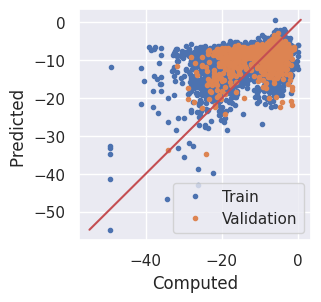

Epoch: 81, Train MAE: 2.9417, Val MAE: 2.9472
Epoch: 82, Train MAE: 2.9410, Val MAE: 2.8981
Epoch: 83, Train MAE: 2.9347, Val MAE: 2.8901
Epoch: 84, Train MAE: 2.9494, Val MAE: 2.9404
Epoch: 85, Train MAE: 2.9593, Val MAE: 2.9014
Epoch: 86, Train MAE: 2.9278, Val MAE: 2.9304
Epoch: 87, Train MAE: 2.9349, Val MAE: 2.9031
Epoch: 88, Train MAE: 2.9254, Val MAE: 2.8954
Epoch: 89, Train MAE: 2.9404, Val MAE: 2.8809
Epoch: 90, Train MAE: 2.9658, Val MAE: 2.9324


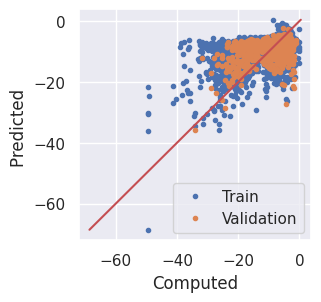

Epoch: 91, Train MAE: 2.9271, Val MAE: 2.9012
Epoch: 92, Train MAE: 2.9185, Val MAE: 2.9212
Epoch: 93, Train MAE: 2.9196, Val MAE: 2.8947
Epoch: 94, Train MAE: 2.9103, Val MAE: 2.8982
Epoch: 95, Train MAE: 2.9231, Val MAE: 2.9168
Epoch: 96, Train MAE: 2.8938, Val MAE: 2.9250
Epoch: 97, Train MAE: 2.9534, Val MAE: 2.9411
Epoch: 98, Train MAE: 2.9358, Val MAE: 2.8959
Epoch: 99, Train MAE: 2.9003, Val MAE: 2.9024
Epoch: 100, Train MAE: 2.8979, Val MAE: 2.9331


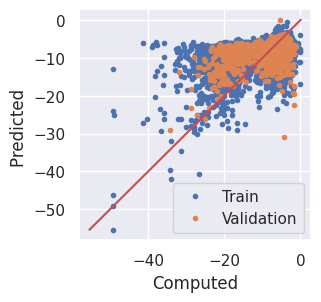

Epoch: 101, Train MAE: 2.9213, Val MAE: 2.9011
Epoch: 102, Train MAE: 2.8948, Val MAE: 2.9436
Epoch: 103, Train MAE: 2.8956, Val MAE: 2.8986
Epoch: 104, Train MAE: 2.8800, Val MAE: 2.8789
Epoch: 105, Train MAE: 2.9046, Val MAE: 2.8773
Epoch: 106, Train MAE: 2.8989, Val MAE: 2.9160
Epoch: 107, Train MAE: 2.8769, Val MAE: 2.9249
Epoch: 108, Train MAE: 2.8867, Val MAE: 2.8925
Epoch: 109, Train MAE: 2.8936, Val MAE: 2.9173
Epoch: 110, Train MAE: 2.8948, Val MAE: 2.9525


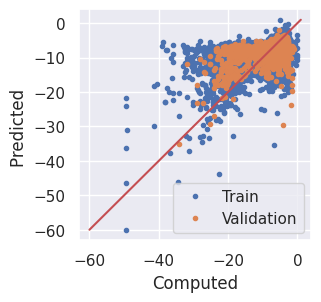

Epoch: 111, Train MAE: 2.9001, Val MAE: 2.8849
Epoch: 112, Train MAE: 2.8788, Val MAE: 2.9008
Epoch: 113, Train MAE: 2.8644, Val MAE: 2.9159
Epoch: 114, Train MAE: 2.8784, Val MAE: 2.8987
Epoch: 115, Train MAE: 2.8870, Val MAE: 2.9304
Epoch: 116, Train MAE: 2.8545, Val MAE: 2.9077
Epoch: 117, Train MAE: 2.8859, Val MAE: 2.8911
Epoch: 118, Train MAE: 2.8754, Val MAE: 2.9012
Epoch: 119, Train MAE: 2.8925, Val MAE: 2.9066
Epoch: 120, Train MAE: 2.8772, Val MAE: 2.9741


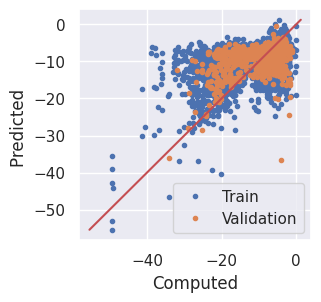

Epoch: 121, Train MAE: 2.8612, Val MAE: 2.9145
Epoch: 122, Train MAE: 2.8915, Val MAE: 2.9455
Epoch: 123, Train MAE: 2.9076, Val MAE: 2.8951
Epoch: 124, Train MAE: 2.8514, Val MAE: 2.8811
Epoch: 125, Train MAE: 2.8541, Val MAE: 2.8919
Epoch: 126, Train MAE: 2.8575, Val MAE: 2.8938
Epoch: 127, Train MAE: 2.8735, Val MAE: 2.9163
Epoch: 128, Train MAE: 2.8651, Val MAE: 2.9550
Epoch: 129, Train MAE: 2.8725, Val MAE: 2.9028
Epoch: 130, Train MAE: 2.8443, Val MAE: 2.9000


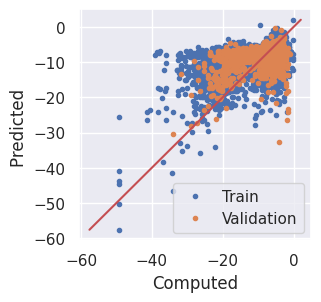

Epoch: 131, Train MAE: 2.8559, Val MAE: 2.9336
Epoch: 132, Train MAE: 2.8293, Val MAE: 2.8775
Epoch: 133, Train MAE: 2.8491, Val MAE: 3.0022
Epoch: 134, Train MAE: 2.8419, Val MAE: 2.9053
Epoch: 135, Train MAE: 2.8991, Val MAE: 2.8846
Epoch: 136, Train MAE: 2.8524, Val MAE: 2.9473
Epoch: 137, Train MAE: 2.8459, Val MAE: 2.8624
Epoch: 138, Train MAE: 2.8416, Val MAE: 2.9777
Epoch: 139, Train MAE: 2.8341, Val MAE: 2.8727
Epoch: 140, Train MAE: 2.8252, Val MAE: 2.9088


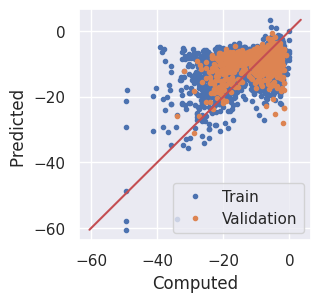

Epoch: 141, Train MAE: 2.8422, Val MAE: 2.9438
Epoch: 142, Train MAE: 2.8347, Val MAE: 2.9704
Epoch: 143, Train MAE: 2.8055, Val MAE: 3.0121
Epoch: 144, Train MAE: 2.8443, Val MAE: 2.8708
Epoch: 145, Train MAE: 2.8288, Val MAE: 2.9651
Epoch: 146, Train MAE: 2.8371, Val MAE: 2.8790
Epoch: 147, Train MAE: 2.8176, Val MAE: 2.8976
Epoch: 148, Train MAE: 2.8202, Val MAE: 2.8268
Epoch: 149, Train MAE: 2.8420, Val MAE: 2.9562
Epoch: 150, Train MAE: 2.8142, Val MAE: 2.8990


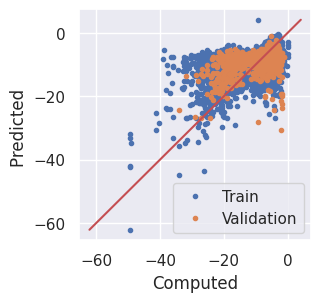

Epoch: 151, Train MAE: 2.8386, Val MAE: 2.9368
Epoch: 152, Train MAE: 2.8453, Val MAE: 2.9029
Epoch: 153, Train MAE: 2.8352, Val MAE: 2.8919
Epoch: 154, Train MAE: 2.8134, Val MAE: 2.9138
Epoch: 155, Train MAE: 2.7985, Val MAE: 2.9735
Epoch: 156, Train MAE: 2.8160, Val MAE: 2.9220
Epoch: 157, Train MAE: 2.8429, Val MAE: 2.8627
Epoch: 158, Train MAE: 2.8426, Val MAE: 2.9056
Epoch: 159, Train MAE: 2.7915, Val MAE: 2.9586
Epoch: 160, Train MAE: 2.8543, Val MAE: 2.8765


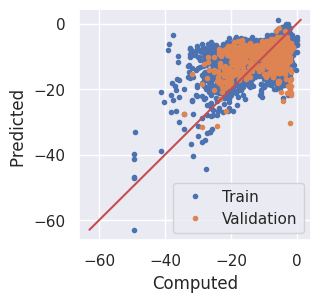

Epoch: 161, Train MAE: 2.8161, Val MAE: 2.9467
Epoch: 162, Train MAE: 2.7904, Val MAE: 2.9039
Epoch: 163, Train MAE: 2.7999, Val MAE: 2.8738
Epoch: 164, Train MAE: 2.7893, Val MAE: 2.8793
Epoch: 165, Train MAE: 2.8026, Val MAE: 2.9411
Epoch: 166, Train MAE: 2.8175, Val MAE: 2.9106
Epoch: 167, Train MAE: 2.7877, Val MAE: 2.9238
Epoch: 168, Train MAE: 2.8608, Val MAE: 2.9240
Epoch: 169, Train MAE: 2.7912, Val MAE: 2.9439
Epoch: 170, Train MAE: 2.8200, Val MAE: 2.9048


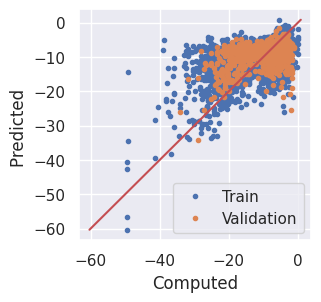

Epoch: 171, Train MAE: 2.8071, Val MAE: 2.8841
Epoch: 172, Train MAE: 2.8208, Val MAE: 2.9402
Epoch: 173, Train MAE: 2.7767, Val MAE: 2.8718
Epoch: 174, Train MAE: 2.7867, Val MAE: 2.9259
Epoch: 175, Train MAE: 2.7880, Val MAE: 2.9083
Epoch: 176, Train MAE: 2.7862, Val MAE: 3.0071
Epoch: 177, Train MAE: 2.8343, Val MAE: 2.8800
Epoch: 178, Train MAE: 2.7794, Val MAE: 2.9182
Epoch: 179, Train MAE: 2.7952, Val MAE: 2.9455
Epoch: 180, Train MAE: 2.7802, Val MAE: 2.8956


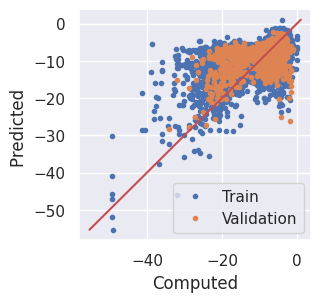

Epoch: 181, Train MAE: 2.7835, Val MAE: 2.8603
Epoch: 182, Train MAE: 2.7886, Val MAE: 2.8639
Epoch: 183, Train MAE: 2.8398, Val MAE: 2.9186
Epoch: 184, Train MAE: 2.7804, Val MAE: 2.8772
Epoch: 185, Train MAE: 2.7568, Val MAE: 2.8920
Epoch: 186, Train MAE: 2.7831, Val MAE: 2.8900
Epoch: 187, Train MAE: 2.7805, Val MAE: 2.9541
Epoch: 188, Train MAE: 2.7918, Val MAE: 2.8833
Epoch: 189, Train MAE: 2.8067, Val MAE: 2.8520
Epoch: 190, Train MAE: 2.7857, Val MAE: 2.8438


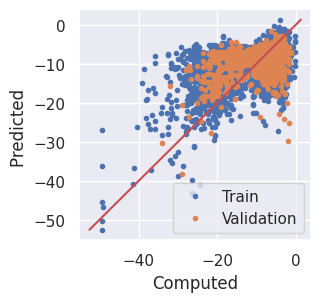

Epoch: 191, Train MAE: 2.7775, Val MAE: 2.9029
Epoch: 192, Train MAE: 2.7717, Val MAE: 2.8341
Epoch: 193, Train MAE: 2.7643, Val MAE: 2.8907
Epoch: 194, Train MAE: 2.7645, Val MAE: 2.9056
Epoch: 195, Train MAE: 2.7694, Val MAE: 2.9240
Epoch: 196, Train MAE: 2.7840, Val MAE: 2.8811
Epoch: 197, Train MAE: 2.7625, Val MAE: 2.8710
Epoch: 198, Train MAE: 2.7649, Val MAE: 2.9440
Epoch: 199, Train MAE: 2.7743, Val MAE: 2.8974
Epoch: 200, Train MAE: 2.7878, Val MAE: 2.9198


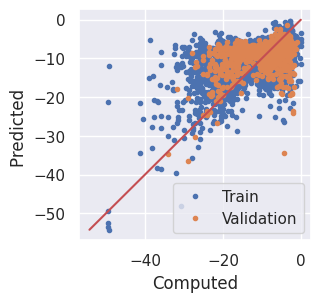

Epoch: 201, Train MAE: 2.7854, Val MAE: 2.9348
Epoch: 202, Train MAE: 2.7811, Val MAE: 2.8749
Epoch: 203, Train MAE: 2.7884, Val MAE: 2.8503
Epoch: 204, Train MAE: 2.7777, Val MAE: 2.8115
Epoch: 205, Train MAE: 2.7726, Val MAE: 2.8530
Epoch: 206, Train MAE: 2.7749, Val MAE: 2.8905
Epoch: 207, Train MAE: 2.7589, Val MAE: 2.8865
Epoch: 208, Train MAE: 2.7542, Val MAE: 2.9154
Epoch: 209, Train MAE: 2.7723, Val MAE: 2.8582
Epoch: 210, Train MAE: 2.7378, Val MAE: 2.8341


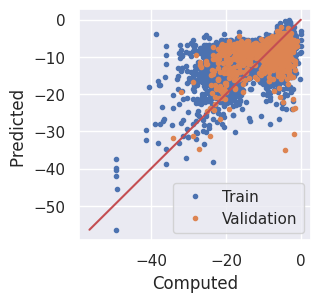

Epoch: 211, Train MAE: 2.7785, Val MAE: 2.9219
Epoch: 212, Train MAE: 2.7407, Val MAE: 2.8723
Epoch: 213, Train MAE: 2.7561, Val MAE: 2.8150
Epoch: 214, Train MAE: 2.7494, Val MAE: 2.8439
Epoch: 215, Train MAE: 2.7493, Val MAE: 2.8220
Epoch: 216, Train MAE: 2.7538, Val MAE: 2.8721
Epoch: 217, Train MAE: 2.7403, Val MAE: 2.8812
Epoch: 218, Train MAE: 2.7463, Val MAE: 2.8625
Epoch: 219, Train MAE: 2.7405, Val MAE: 2.9317
Epoch: 220, Train MAE: 2.7543, Val MAE: 2.8374


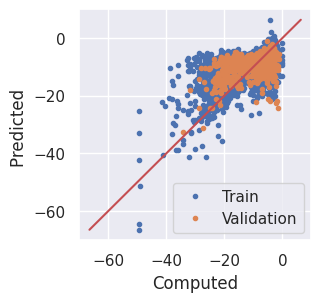

Epoch: 221, Train MAE: 2.7512, Val MAE: 2.8585
Epoch: 222, Train MAE: 2.7500, Val MAE: 2.8881
Epoch: 223, Train MAE: 2.7516, Val MAE: 2.8117
Epoch: 224, Train MAE: 2.8226, Val MAE: 2.8393
Epoch: 225, Train MAE: 2.7735, Val MAE: 2.9498
Epoch: 226, Train MAE: 2.7535, Val MAE: 2.9133
Epoch: 227, Train MAE: 2.7418, Val MAE: 2.8701
Epoch: 228, Train MAE: 2.7601, Val MAE: 2.9145
Epoch: 229, Train MAE: 2.7500, Val MAE: 2.8883
Epoch: 230, Train MAE: 2.7246, Val MAE: 2.8528


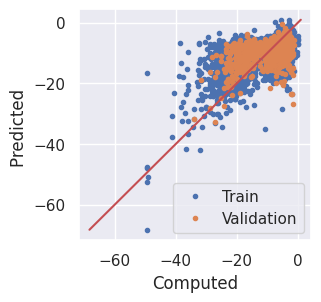

Epoch: 231, Train MAE: 2.7281, Val MAE: 2.8608
Epoch: 232, Train MAE: 2.7552, Val MAE: 2.9157
Epoch: 233, Train MAE: 2.7374, Val MAE: 2.8398
Epoch: 234, Train MAE: 2.7741, Val MAE: 2.8568
Epoch: 235, Train MAE: 2.7352, Val MAE: 2.7985
Epoch: 236, Train MAE: 2.7301, Val MAE: 2.9100
Epoch: 237, Train MAE: 2.7371, Val MAE: 2.9057
Epoch: 238, Train MAE: 2.7431, Val MAE: 2.8598
Epoch: 239, Train MAE: 2.7548, Val MAE: 2.8547
Epoch: 240, Train MAE: 2.7505, Val MAE: 2.8875


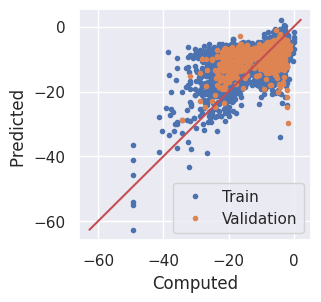

Epoch: 241, Train MAE: 2.7293, Val MAE: 2.8558
Epoch: 242, Train MAE: 2.7419, Val MAE: 2.8612
Epoch: 243, Train MAE: 2.7185, Val MAE: 2.8848
Epoch: 244, Train MAE: 2.7215, Val MAE: 2.8682
Epoch: 245, Train MAE: 2.7397, Val MAE: 2.8045
Epoch: 246, Train MAE: 2.7321, Val MAE: 2.8244
Epoch: 247, Train MAE: 2.7256, Val MAE: 2.8661
Epoch: 248, Train MAE: 2.7216, Val MAE: 2.8415
Epoch: 249, Train MAE: 2.7125, Val MAE: 2.7965
Epoch: 250, Train MAE: 2.7151, Val MAE: 2.9032


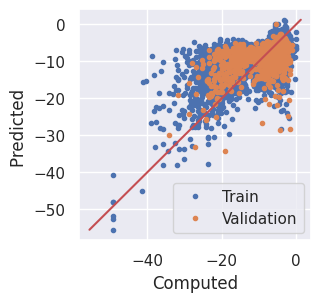

Epoch: 251, Train MAE: 2.7270, Val MAE: 2.8800
Epoch: 252, Train MAE: 2.7290, Val MAE: 2.8500
Epoch: 253, Train MAE: 2.7342, Val MAE: 2.8904
Epoch: 254, Train MAE: 2.7232, Val MAE: 2.8413
Epoch: 255, Train MAE: 2.7155, Val MAE: 2.8892
Epoch: 256, Train MAE: 2.7253, Val MAE: 2.8444
Epoch: 257, Train MAE: 2.7093, Val MAE: 2.8637
Epoch: 258, Train MAE: 2.7249, Val MAE: 2.8988
Epoch: 259, Train MAE: 2.7496, Val MAE: 2.8111
Epoch: 260, Train MAE: 2.7122, Val MAE: 2.9277


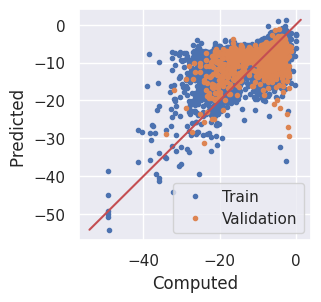

Epoch: 261, Train MAE: 2.7344, Val MAE: 2.8621
Epoch: 262, Train MAE: 2.6912, Val MAE: 2.8642
Epoch: 263, Train MAE: 2.7237, Val MAE: 2.8464
Epoch: 264, Train MAE: 2.7102, Val MAE: 2.8180
Epoch: 265, Train MAE: 2.7100, Val MAE: 2.8719
Epoch: 266, Train MAE: 2.7050, Val MAE: 2.8497
Epoch: 267, Train MAE: 2.7017, Val MAE: 2.8175
Epoch: 268, Train MAE: 2.6945, Val MAE: 2.8283
Epoch: 269, Train MAE: 2.7600, Val MAE: 2.8923
Epoch: 270, Train MAE: 2.8613, Val MAE: 2.8811


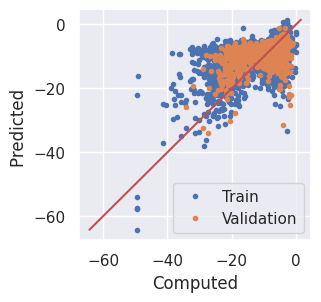

Epoch: 271, Train MAE: 2.7953, Val MAE: 2.8957
Epoch: 272, Train MAE: 2.7426, Val MAE: 2.8456
Epoch: 273, Train MAE: 2.7524, Val MAE: 2.8706
Epoch: 274, Train MAE: 2.7115, Val MAE: 2.8174
Epoch: 275, Train MAE: 2.7133, Val MAE: 2.8091
Epoch: 276, Train MAE: 2.7790, Val MAE: 2.8798
Epoch: 277, Train MAE: 2.7142, Val MAE: 2.8765
Epoch: 278, Train MAE: 2.7039, Val MAE: 2.8668
Epoch: 279, Train MAE: 2.6864, Val MAE: 2.8500
Epoch: 280, Train MAE: 2.7034, Val MAE: 2.7987


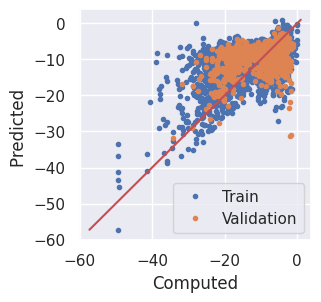

Epoch: 281, Train MAE: 2.6911, Val MAE: 2.8932
Epoch: 282, Train MAE: 2.7058, Val MAE: 2.8396
Epoch: 283, Train MAE: 2.7060, Val MAE: 2.8396
Epoch: 284, Train MAE: 2.6964, Val MAE: 2.8514
Epoch: 285, Train MAE: 2.6919, Val MAE: 2.9404
Epoch: 286, Train MAE: 2.7186, Val MAE: 2.8450
Epoch: 287, Train MAE: 2.6890, Val MAE: 2.9367
Epoch: 288, Train MAE: 2.6948, Val MAE: 2.8276
Epoch: 289, Train MAE: 2.7352, Val MAE: 2.9135
Epoch: 290, Train MAE: 2.6876, Val MAE: 2.8477


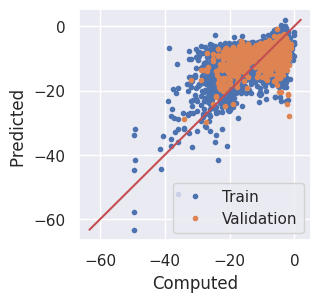

Epoch: 291, Train MAE: 2.6944, Val MAE: 2.8602
Epoch: 292, Train MAE: 2.6837, Val MAE: 2.9228
Epoch: 293, Train MAE: 2.7257, Val MAE: 2.8753
Epoch: 294, Train MAE: 2.6933, Val MAE: 2.8698
Epoch: 295, Train MAE: 2.6688, Val MAE: 2.8708
Epoch: 296, Train MAE: 2.6890, Val MAE: 2.8216
Epoch: 297, Train MAE: 2.6838, Val MAE: 2.8514
Epoch: 298, Train MAE: 2.7019, Val MAE: 2.9722
Epoch: 299, Train MAE: 2.6816, Val MAE: 2.8571
Epoch: 300, Train MAE: 2.6916, Val MAE: 2.8440


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

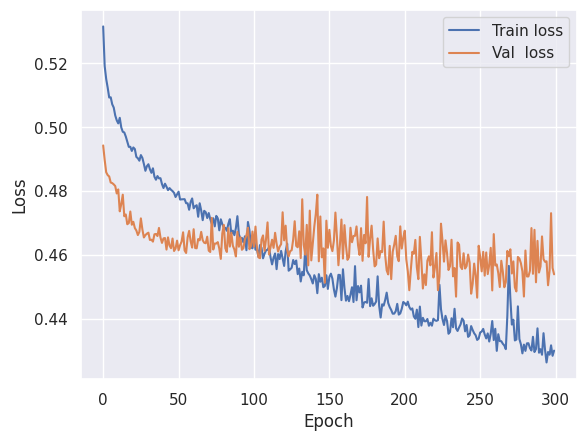

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=16, bias=True)
    (lin2): Linear(in_features=16, out_features=8, bias=True)
    (lin): Linear(in_features=8, out_features=1, bias=True)
  )
)

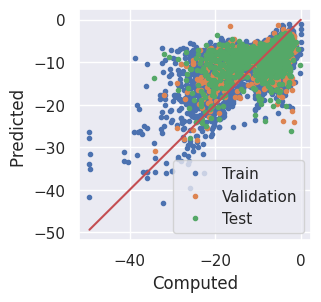

Train MAE: 2.6181, Val MAE: 2.7965, Test MAE: 2.9215


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
